In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from analysis import datasets
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import weibull_min
from scipy.special import gamma
from analysis.explorative_analysis import *

# 50Hertz Daten

## Daten laden

In [3]:
df = datasets.load_entsoe()

First 5 rows of the dataframe:


,offshore,onshore
time,,
2016-01-01 00:00:00,21.0,1428.0
2016-01-01 00:15:00,27.0,1379.0
2016-01-01 00:30:00,24.0,1399.0
2016-01-01 00:45:00,20.0,1448.0
2016-01-01 01:00:00,16.0,1517.0



Last 5 rows of the dataframe:


,offshore,onshore
time,,
2024-12-31 22:45:00,NaN,NaN
2024-12-31 23:00:00,NaN,NaN
2024-12-31 23:15:00,NaN,NaN
2024-12-31 23:30:00,NaN,NaN
2024-12-31 23:45:00,NaN,NaN



Summary statistics of the dataframe:


,offshore,onshore
count,307842.000000,307842.000000
mean,369.573703,3727.880780
std,346.738522,3359.502551
min,0.000000,0.000000
25%,75.000000,1109.250000
50%,272.000000,2634.000000
75%,600.000000,5413.750000
max,1480.000000,16676.000000



Shape of the dataframe (rows, columns):


(315648, 2)


Checking for duplicates in the index:
Index column has no duplicates.

Rows with NaN values:


,offshore,onshore
time,,
2024-10-11 16:30:00,NaN,NaN
2024-10-11 16:45:00,NaN,NaN
2024-10-11 17:00:00,NaN,NaN
2024-10-11 17:15:00,NaN,NaN
2024-10-11 17:30:00,NaN,NaN
...,...,...
2024-12-31 22:45:00,NaN,NaN
2024-12-31 23:00:00,NaN,NaN
2024-12-31 23:15:00,NaN,NaN



First index with NaN values:
2024-10-11 16:30:00

Columns containing 'Power (kW)' or named 'onshore':
Plotting histogram for: onshore


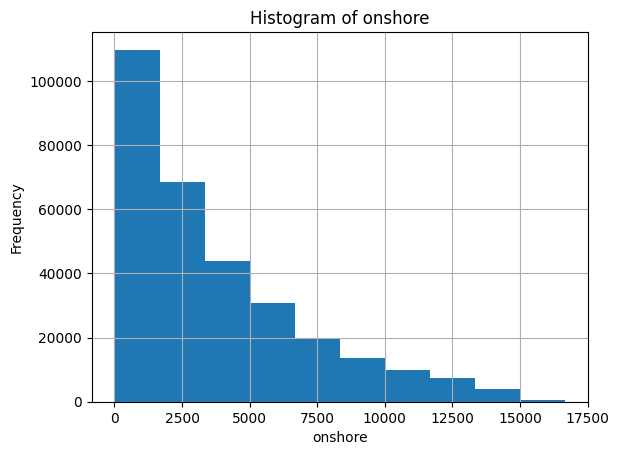


Plotting monthly time series of onshore data:


C:\Users\Manuel\Documents\Masterarbeit\src\analysis\explorative_analysis.py:91: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = dataframe.resample('M').mean()  # Resample by month, taking the mean


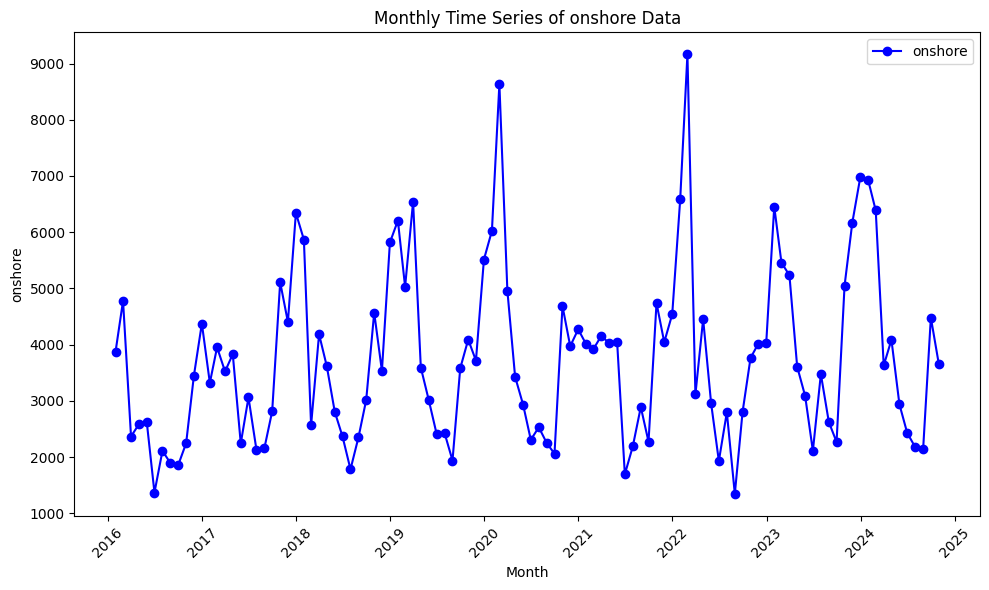

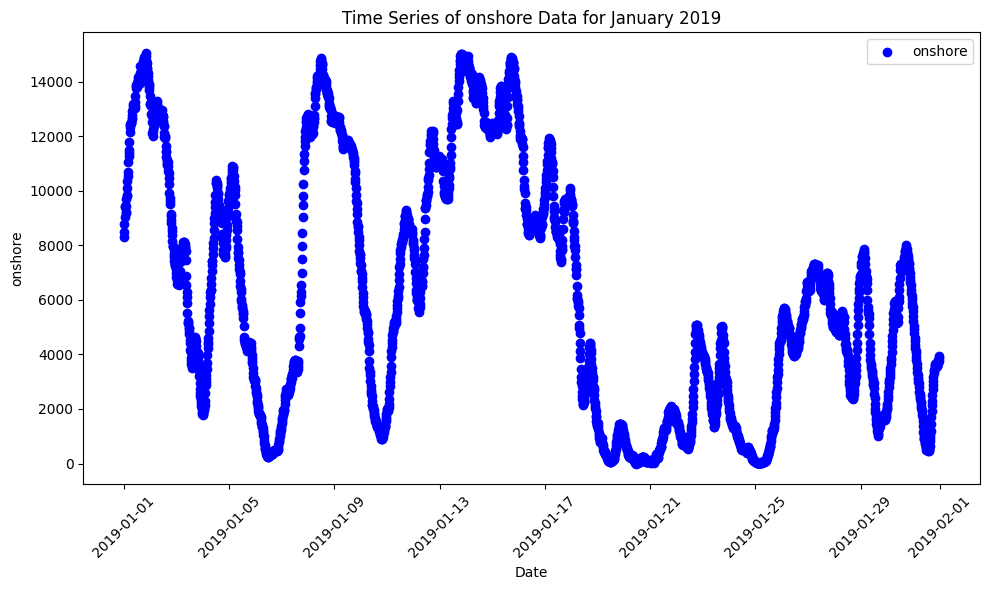

In [4]:
explorative_analysis(df)

# Alt

## Expected number of entries = actual number of entries

In [5]:
#expected_no_entries(df)

## Time Series of mean per month

C:\Users\Manuel\AppData\Local\Temp\ipykernel_6748\939413964.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample('M').mean()  # Resample by month, taking the mean


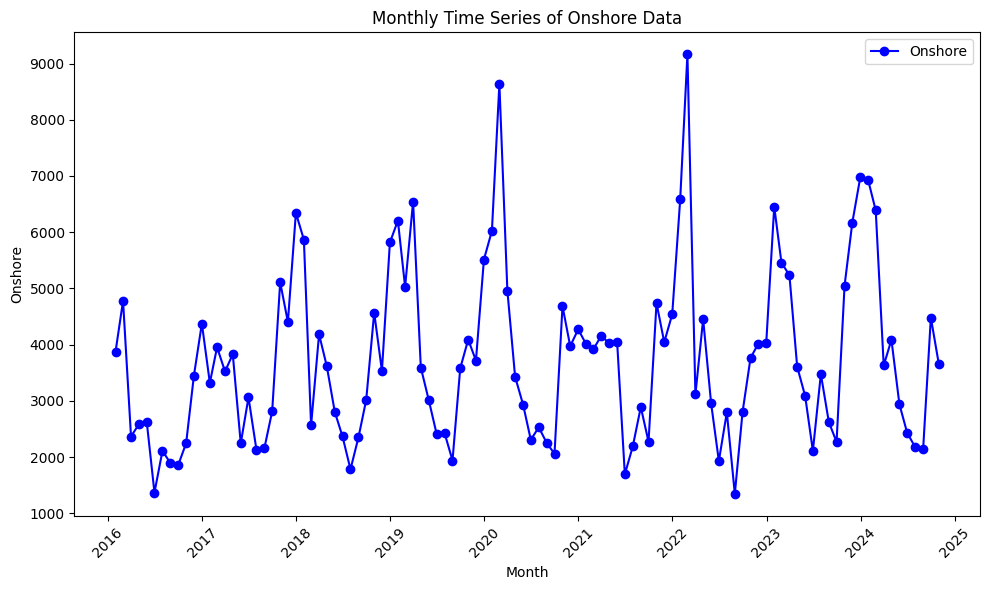

In [6]:
monthly_data = df.resample('M').mean()  # Resample by month, taking the mean
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data['onshore'], marker='o', linestyle='-', color='b', label='Onshore')
plt.title('Monthly Time Series of Onshore Data')
plt.xlabel('Month')
plt.ylabel('Onshore')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Time Series of 1 month

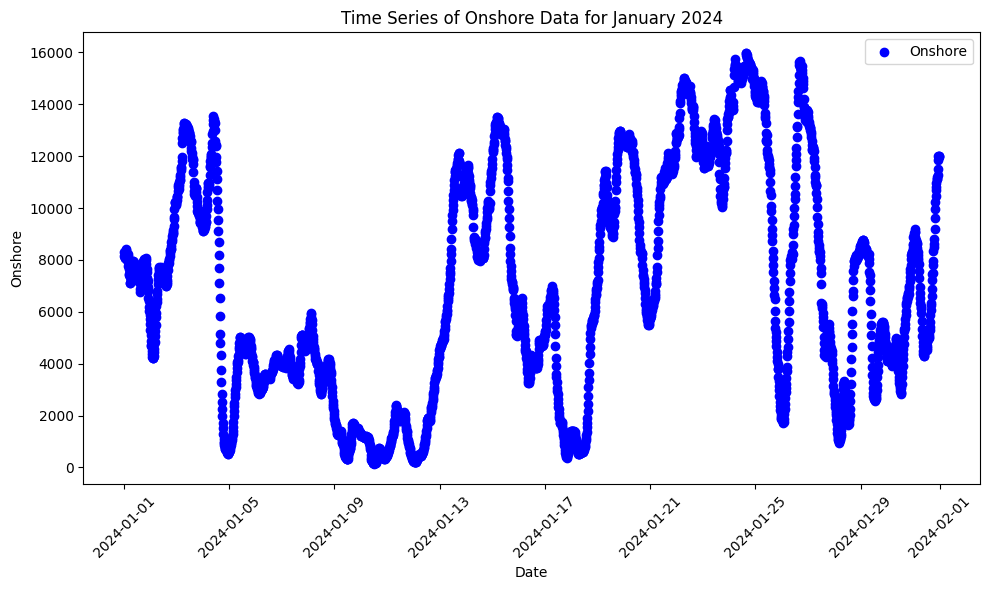

In [7]:
# Filter the data for January 2024 (or any month you want)
filtered_data = df.loc['2024-01']  # This will return all data for January 2024

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data.index, filtered_data['onshore'], color='b', label='Onshore')
plt.title('Time Series of Onshore Data for January 2024')
plt.xlabel('Date')
plt.ylabel('Onshore')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# First Analyses

### I want to analyze for each 15 minute interval which distribution fits the data best. To this end, I turn the data frame into new one with index = day and 96 columns (one per time interval) (both onshore and offshore)

In [8]:
def minute_to_daily(df):
    df = df.copy()
    original_shape = df.shape
    original_frequency = int((df.index[1] - df.index[0]).seconds / 60)

    if isinstance(df, pd.Series):
        df = df.to_frame()

    columns = df.columns
    df.index.name = ""
    df.index = pd.to_datetime(df.index)

    # Extract the date and formatted time
    df["date"] = df.index.date
    df["time"] = df.index.strftime("%H_%M")

    # Perform the pivot (reshape)
    reshaped_df = df.pivot(index="date", columns="time", values=columns)

    # Flatten multi-level columns if necessary
    reshaped_df.columns = [f"{col[0]}_{col[1]}" for col in reshaped_df.columns]
    if reshaped_df.index.dtype == "object":
        reshaped_df.index = pd.to_datetime(reshaped_df.index)

    return reshaped_df

In [9]:
reshaped = minute_to_daily(df)
reshaped

,offshore_00_00,offshore_00_15,offshore_00_30,offshore_00_45,offshore_01_00,offshore_01_15,offshore_01_30,offshore_01_45,offshore_02_00,offshore_02_15,...,onshore_21_30,onshore_21_45,onshore_22_00,onshore_22_15,onshore_22_30,onshore_22_45,onshore_23_00,onshore_23_15,onshore_23_30,onshore_23_45
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,21.0,27.0,24.0,20.0,16.0,14.0,8.0,5.0,5.0,6.0,...,316.0,350.0,359.0,385.0,425.0,432.0,467.0,503.0,509.0,528.0
2016-01-02,208.0,226.0,235.0,260.0,292.0,303.0,295.0,280.0,287.0,285.0,...,6813.0,6809.0,6785.0,6760.0,6790.0,6771.0,6700.0,6682.0,6672.0,6721.0
2016-01-03,320.0,320.0,321.0,320.0,321.0,321.0,321.0,320.0,321.0,321.0,...,5377.0,5335.0,5253.0,5296.0,5265.0,5255.0,5255.0,5239.0,5234.0,5220.0
2016-01-04,319.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,...,2284.0,2195.0,2177.0,2173.0,2165.0,2183.0,2194.0,2136.0,2100.0,2050.0
2016-01-05,320.0,319.0,319.0,320.0,319.0,319.0,319.0,320.0,319.0,319.0,...,1475.0,1441.0,1391.0,1414.0,1420.0,1397.0,1353.0,1341.0,1218.0,1121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Analyse the daily time series for each 15-minute interval separately. To be more flexible fit a Weibull distribution rather than a Gaussian distribution. The most important parameter is the "shape" parameter. For "shape" <= 1 the maximum of the distribution is at zero; for "shape" > 1 the maximum is above zero. The scale parameter simply says how large the variable can be

In [10]:
def get_weibull_mle(data):
    data = data[np.isfinite(data)]
    shape_param, loc, scale_param = weibull_min.fit(data, floc=0)  # floc=0 fixes the location parameter
    return shape_param, scale_param

def get_weibull_mles(data):
    mles = []
    for column in data.columns:
        shape, scale = get_weibull_mle(data[column])
        th_mean = scale*gamma(1+1/shape)
        mean = data[column].mean()
        error = (th_mean - mean) / mean
        mles.append({"time_interval": column, "shape": shape, "scale": scale, "th_mean": th_mean, "mean": mean, "error": error})
    return pd.DataFrame(mles)

### Focuses on onshore

In [11]:
data = minute_to_daily(df)
mles = get_weibull_mles(data)
onshore = mles[mles['time_interval'].str.startswith('onshore')]
onshore

,time_interval,shape,scale,th_mean,mean,error
96,onshore_00_00,1.234070,4234.751879,3955.959383,3951.308388,0.001177
97,onshore_00_15,1.229869,4216.769248,3942.362660,3937.562208,0.001219
98,onshore_00_30,1.223095,4197.718625,3929.791219,3925.318990,0.001139
99,onshore_00_45,1.216945,4177.616407,3915.812628,3911.964765,0.000984
100,onshore_01_00,1.211925,4157.172339,3900.658748,3897.234799,0.000879
...,...,...,...,...,...,...
187,onshore_22_45,1.252746,4328.702775,4029.673580,4024.471304,0.001293
188,onshore_23_00,1.249402,4310.649440,4015.307062,4010.149095,0.001286
189,onshore_23_15,1.245312,4292.834732,4001.722830,3996.628197,0.001275
190,onshore_23_30,1.241225,4274.951816,3988.090456,3983.315346,0.001199


## Plotting the distribution of the "shape" parameter for the 96 time intervals (onshore). We see that most often positive power is produced. 

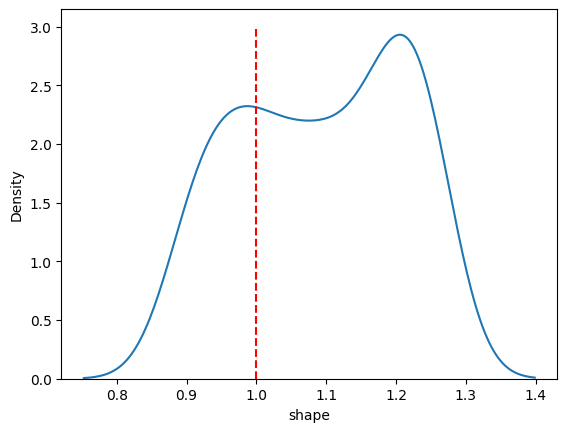

In [12]:
sns.kdeplot(onshore["shape"])
plt.vlines(x=1, ymin=0, ymax=3, color='r', linestyle='--')

<Axes: xlabel='scale', ylabel='Density'>

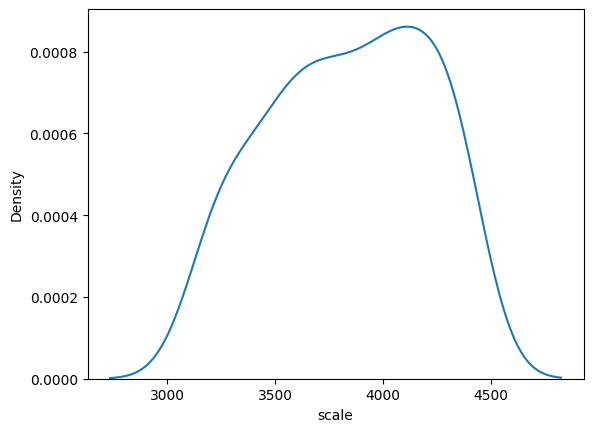

In [13]:
sns.kdeplot(onshore["scale"])

In [14]:
onshore.describe()

,shape,scale,th_mean,mean,error
count,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.093060,3840.267505,3730.255973,3727.901327,0.000613
std,0.117415,367.530699,216.924309,215.568324,0.000437
min,0.894309,3177.622580,3354.382344,3351.692236,-0.000040
25%,0.990418,3555.595492,3571.616935,3571.588167,0.000116
50%,1.099554,3856.923470,3720.281221,3717.975226,0.000701
75%,1.200338,4143.692478,3903.837306,3900.233414,0.000996
max,1.257247,4384.085683,4080.402494,4075.634124,0.001293


### Find values with shape < 1

In [15]:
onshore[onshore['shape'] <= 0.9]

,time_interval,shape,scale,th_mean,mean,error
126,onshore_07_30,0.897159,3193.459460,3365.941562,3362.995011,0.000876
127,onshore_07_45,0.894309,3177.622580,3355.146064,3352.166511,0.000889
128,onshore_08_00,0.896678,3181.552412,3354.382344,3351.692236,0.000803


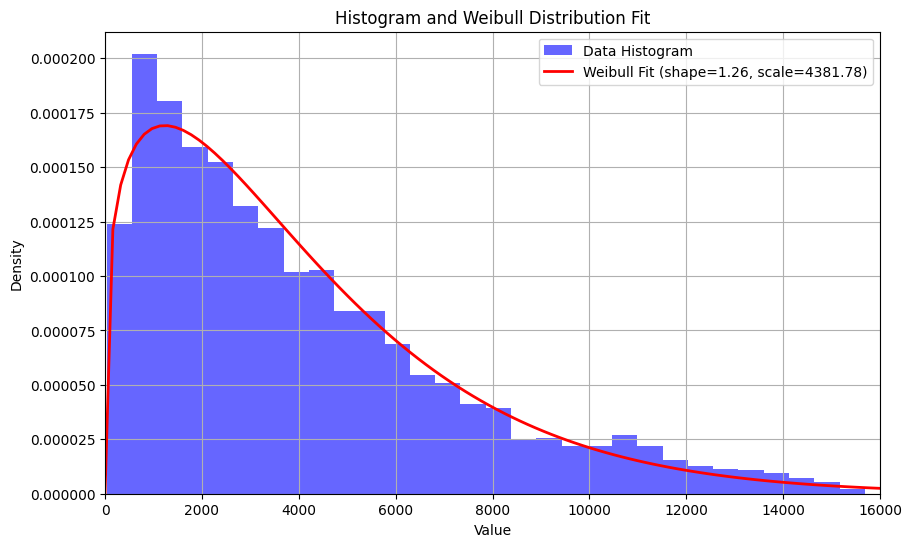

In [16]:
# Step 1: Get the data from the DataFrame

## interessanter Wert 07_30
data = minute_to_daily(df)['onshore_21_30']

# Step 2: Clean the data by removing NaN and infinite values
data_clean = data[np.isfinite(data)]

# Step 3: Plot the histogram of the cleaned data
plt.figure(figsize=(10, 6))
plt.hist(data_clean, bins=30, density=True, alpha=0.6, color='blue', label='Data Histogram')

# Step 4: Fit the Weibull distribution to the cleaned data
shape_param, loc, scale_param = weibull_min.fit(data_clean, floc=0)  # floc=0 fixes the location parameter

# Step 5: Generate x values for the Weibull PDF within the specified range
x = np.linspace(0, 16000, 100)  # Specify range from 0 to 16000

# Step 6: Calculate the Weibull PDF
weibull_pdf = weibull_min.pdf(x, shape_param, loc=loc, scale=scale_param)

# Step 7: Plot the Weibull distribution
plt.plot(x, weibull_pdf, 'r-', lw=2, label='Weibull Fit (shape={:.2f}, scale={:.2f})'.format(shape_param, scale_param))

# Finalize the plot
plt.title('Histogram and Weibull Distribution Fit')
plt.xlabel('Value')
plt.ylabel('Density')
plt.xlim(0, 16000)  # Set x-axis limits from 0 to 16000
plt.legend()
plt.grid()
plt.show()

### First attempt to include installed capacity. Since data is updated yearly only, I need to interpolate. This is an approximation since in reality more capacity is not added continuously 

In [17]:
def load_installed_capacity(start_date="2017-01-01", end_date="2024-01-01", method="linear"):

    data = {
        'date': ['2017-06-01', '2018-06-01', '2019-06-01', '2020-06-01', '2021-06-01', '2022-06-01', '2023-06-01'],
        'installed_capacity': [17866, 18346, 18711, 19138, 19748, 20414, 21078]
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Convert 'year' column to datetime format
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Set 'year' as the index
    df.set_index('date', inplace=True)

    # Resample to 15-minute intervals and interpolate using the specified method
    df = df.resample("15min").interpolate(method=method)

    dt = pd.date_range(start_date, end_date, inclusive="left", freq="15min")
    df = df.reindex(dt).bfill().ffill()

    return df

In [18]:
load_installed_capacity("2016-01-01")

,installed_capacity
2016-01-01 00:00:00,17866.0
2016-01-01 00:15:00,17866.0
2016-01-01 00:30:00,17866.0
2016-01-01 00:45:00,17866.0
2016-01-01 01:00:00,17866.0
...,...
2023-12-31 22:45:00,21078.0
2023-12-31 23:00:00,21078.0
2023-12-31 23:15:00,21078.0
2023-12-31 23:30:00,21078.0


<Axes: >

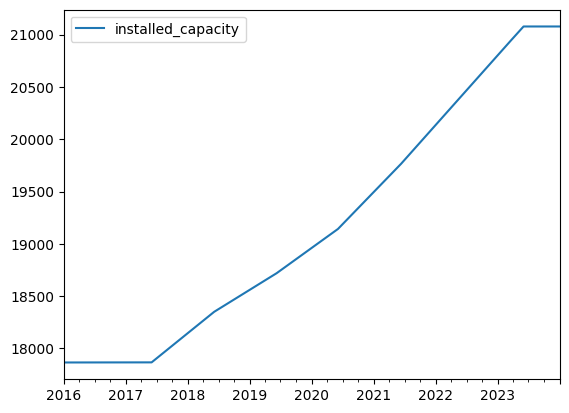

In [19]:
load_installed_capacity("2016-01-01").plot()

In [20]:
df["installed_capacity"] = load_installed_capacity()

### The red line shows the maximum power output achieved and green the installed capacity. The increase is more or less parallel, showing that it makes sense to consider a normalized power output.

<Axes: xlabel='time'>

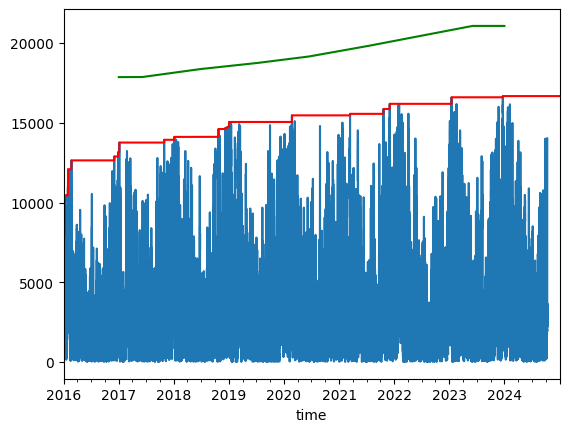

In [21]:
df.onshore.plot()
df.onshore.expanding().max().plot(color="red")
df.installed_capacity.plot(color="green")

In [22]:
[(x, df.resample('M').mean().onshore.autocorr(lag=x).item()) for x in range(1,13)]

C:\Users\Manuel\AppData\Local\Temp\ipykernel_6748\2439084807.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [(x, df.resample('M').mean().onshore.autocorr(lag=x).item()) for x in range(1,13)]


[(1, 0.5770799139372375),
 (2, 0.35482357670480863),
 (3, 0.08007000357315934),
 (4, -0.25325059029392033),
 (5, -0.4426484640194058),
 (6, -0.5301825773505263),
 (7, -0.5055350008591731),
 (8, -0.30578259266058805),
 (9, 0.08583779962474979),
 (10, 0.2742620857564904),
 (11, 0.5233328912991689),
 (12, 0.5882317626328973)]

C:\Users\Manuel\AppData\Local\Temp\ipykernel_6748\636422414.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.plotting.autocorrelation_plot(df.resample('M').mean().offshore)


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

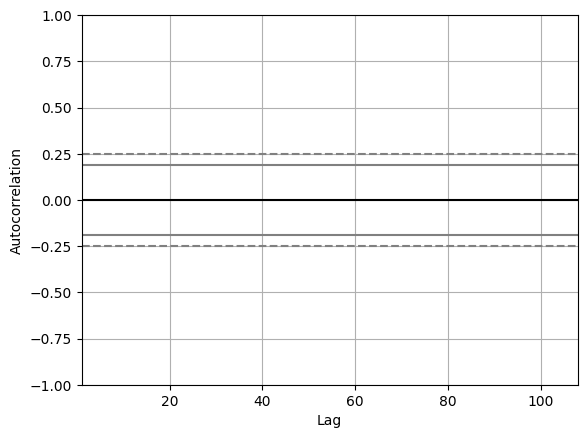

In [23]:
pd.plotting.autocorrelation_plot(df.resample('M').mean().offshore)

In [24]:
# Plot the data
#df.plot(title="Time Series Data")
df2 = df.resample('D').mean()
column = "onshore"
# 1. Autocorrelation and Partial Autocorrelation to detect periodicity
lag_acf = acf(df2[column], nlags=40)
lag_pacf = pacf(df2[column], nlags=40)
display(lag_acf)
display(lag_pacf)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

array([ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

c:\Users\Manuel\Documents\Masterarbeit\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
c:\Users\Manuel\Documents\Masterarbeit\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
c:\Users\Manuel\Documents\Masterarbeit\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                onshore   No. Observations:               315648
Model:                 ARIMA(2, 0, 2)   Log Likelihood            -1874333.890
Date:                Fri, 08 Nov 2024   AIC                        3748679.781
Time:                        15:30:40   BIC                        3748743.755
Sample:                    01-01-2016   HQIC                       3748698.245
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3727.8808    112.053     33.269      0.000    3508.262    3947.500
ar.L1          1.8909      0.001   1970.362      0.000       1.889       1.893
ar.L2         -0.8920      0.001   -930.731      0.0

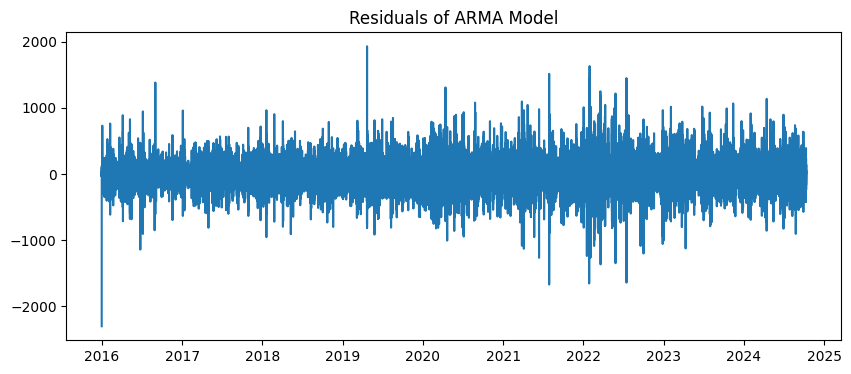

In [25]:
# 2. Fit an ARMA model to the data (ARMA(p,q) model)
model = ARIMA(df[column], order=(2, 0, 2))  # ARMA is a special case of ARIMA(p, 0, q)
arma_model = model.fit()

# Print the summary of the fitted model
print(arma_model.summary())

# 3. Analyze the residuals to check for periodicity in the residuals
residuals = arma_model.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of ARMA Model')
plt.show()

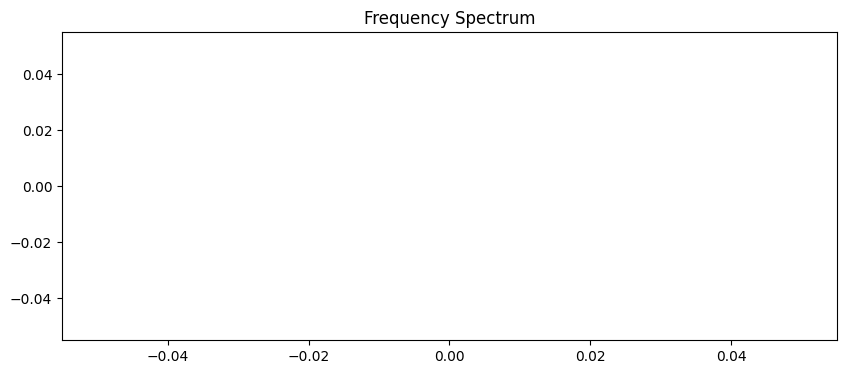

In [26]:
# 4. Optionally, use FFT to find periodicity
fft_vals = np.fft.fft(df[column])
fft_freq = np.fft.fftfreq(len(fft_vals))

plt.figure(figsize=(10, 4))
plt.plot(fft_freq, np.abs(fft_vals))
plt.title('Frequency Spectrum')
plt.show()

In [27]:
lag_acf

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [28]:
lag_pacf

array([ 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

<Axes: >

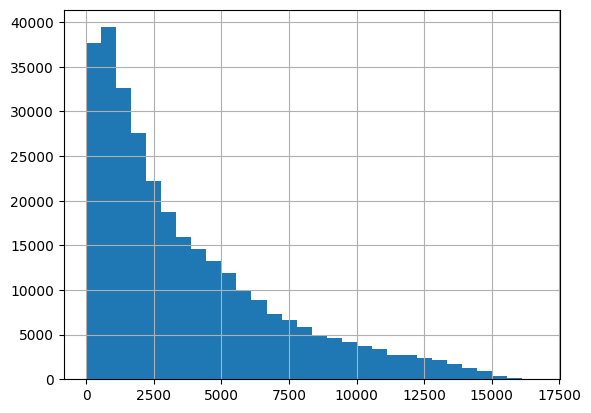

In [29]:
df.onshore.hist(bins=30)

<Axes: >

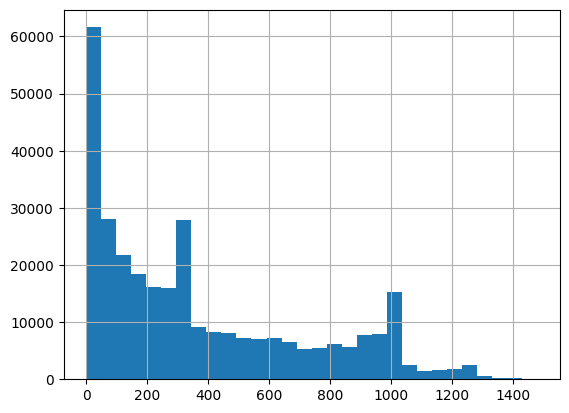

In [30]:
df.offshore.hist(bins=30)

<Axes: xlabel='onshore', ylabel='Density'>

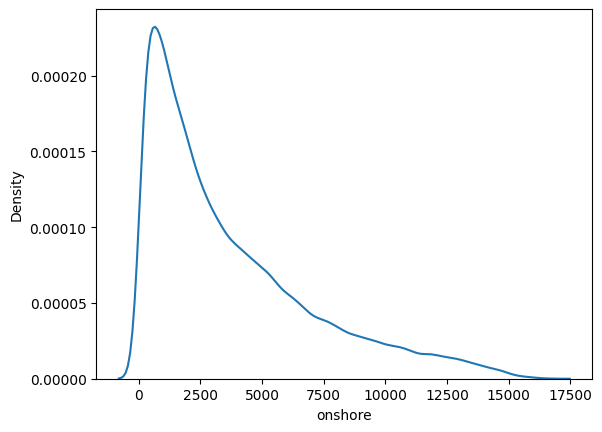

In [31]:
sns.kdeplot(df.onshore)

<Axes: xlabel='offshore', ylabel='Density'>

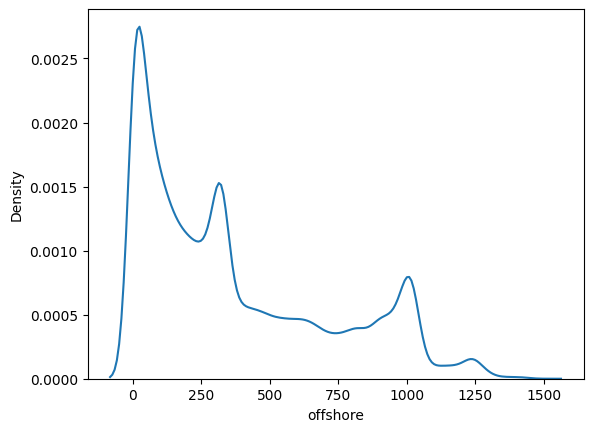

In [32]:
sns.kdeplot(df.offshore)

In [33]:
df.Area.unique()

AttributeError: 'DataFrame' object has no attribute 'Area'